  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

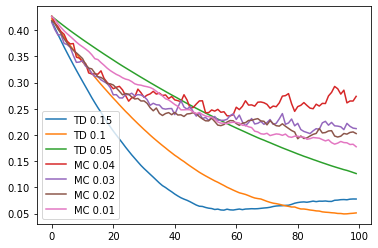

In [68]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/hofmann/nngame/package/src/rlbase/")

import env_random_walk
import policy
import misc

from tqdm.notebook import tqdm

s0 = 3
N = 2*s0-1

env = env_random_walk.RandomWalkEnvironment()
env.env_init({"nmax":N})
pi = policy.DeterministicPolicy(env.states,env.actions)

v_true = misc.evaluate_policy_linear_system(env,pi)
v_true = [v for v in v_true.values()]

gamma = 1

runs = 100
n_episodes = 100

legends = []
for alpha in tqdm([0.15,0.1,0.05,0.04,0.03,0.02,0.01]):
  e_mc = np.zeros((n_episodes,1))
  e_td = np.zeros((n_episodes,1))
  for run in tqdm(range(runs),leave=False):
    v_init = np.ones((N+2,1))*0.5
    v_mc = v_init.copy()
    v_td = v_init.copy()
        
    for i in range(n_episodes):
      s = s0
      episode = []
      while True:
        r, s_prime, terminal = env.env_step(s,0)
        episode += [(s,r)]
        if terminal:
          v_td[s] += alpha * (r - v_td[s] )
          break
        else:
          v_td[s] += alpha * (r + gamma * v_td[s_prime] - v_td[s])
        s = s_prime
      G = 0
      for (s,r) in episode[::-1]:
        G = gamma * G + r
        v_mc[s] += alpha * ( G - v_mc[s] )  
      e_mc[i] += (np.sum((v_mc[1:N+1]-v_true[1:N+1])**2))**.5/runs/5**.5
      e_td[i] += (np.sum((v_td[1:N+1]-v_true[1:N+1])**2))**.5/runs/5**.5
  if alpha>=0.05:
    plt.plot(e_td)
    legends += ["TD "+str(alpha)]
  else:
    plt.plot(e_mc)
    legends += ["MC "+str(alpha)]
plt.legend(tuple(legends))  

<IPython.core.display.Javascript object>


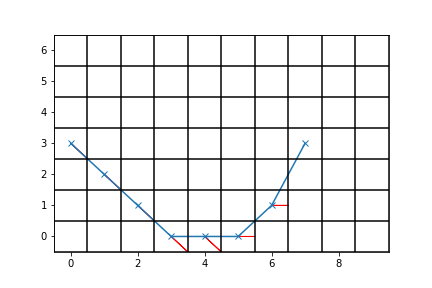

100%|██████████| 500/500 [00:12<00:00, 40.30it/s]


<IPython.core.display.Javascript object>


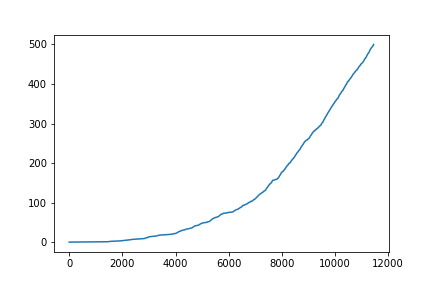

In [128]:
%matplotlib notebook

import matplotlib.pyplot as plt

import env_gridworld, policy, agent_sarsa, experiment_td_ctrl
reload(env_gridworld)
reload(policy)
reload(agent_sarsa)
reload(experiment_td_ctrl)

from env_gridworld import WindyGridworldEnvironment
from policy import EpsSoft
from agent_sarsa import SarsaAgent
from agent_qlearning import QlearningAgent
from experiment_td_ctrl import TD_CtrlExperiment

env = WindyGridworldEnvironment()
env.add_diagonal()
env.add_stay()

p = EpsSoft(env.states,env.actions,eps=0.1)

agent = SarsaAgent()
#agent = QlearningAgent()
agent.agent_init({"pi":p,"env":env})

exp = TD_CtrlExperiment(env,agent)

lens = []
timesteps = [0]
eee = []
fig = plt.figure()

import time

def plot(i,episode):
  global lens, timesteps
  lens += [len(episode)]
  timesteps += [timesteps[-1]+len(episode)]
  if i%10==0:
    plt.clf()
    x = [a[0][0] for a in episode] + [env.goal[0]]
    y = [a[0][1] for a in episode] + [env.goal[1]]
    plt.plot(x,y,'-x')
    for j in range(env.sx+1):
      plt.plot([j-.5,j-.5],[-.5,env.sy-.5],'k-')
    for j in range(env.sy+1):
      plt.plot([-.5,env.sx-.5],[j-.5,j-.5],'k-')
    for a in episode:
      dx, dy = (0,0)
      if "right" in a[1]:
        dx += .5
      if "up" in a[1]:
        dy += .5
      if "left" in a[1]:
        dx -= .5
      if "down" in a[1]:
        dy -= .5
      plt.arrow(a[0][0],a[0][1],dx,dy,color="r")
    plt.xlim(-.5,env.sx-.5)
    plt.ylim(-.5,env.sy-.5)
    fig.canvas.draw()
    time.sleep(0.1)
    
exp.experiment_init({"n_episodes":500,"callback":plot})
exp.train()

plt.figure()
plt.plot(timesteps,list(range(len(timesteps))))

In [117]:
from env_gridworld import CliffGridworldEnvironment

env = CliffGridworldEnvironment()